In [ ]:
import requests

collection_id = 189
url = "https://api-production.data.gov.sg/v2/public/api/collections/{}/metadata".format(collection_id)

response = requests.get(url)
print(response.json())

{'code': 0, 'data': {'collectionMetadata': {'collectionId': '189', 'createdAt': '2015-09-22T15:05:30+08:00', 'name': 'Resale Flat Prices', 'description': 'Resale transacted prices. \r\nPrior to March 2012, data is based on date of approval for the resale transactions.  \r\nFor March 2012 onwards, the data is based on date of registration for the resale transactions.', 'lastUpdatedAt': '2024-12-24T08:56:22+08:00', 'coverageStart': '1990-01-01T08:00:00+08:00', 'coverageEnd': '2024-04-08T00:00:00+08:00', 'frequency': 'monthly', 'sources': ['Housing & Development Board'], 'managedBy': 'Housing & Development Board', 'childDatasets': ['d_8b84c4ee58e3cfc0ece0d773c8ca6abc', 'd_43f493c6c50d54243cc1eab0df142d6a', 'd_2d5ff9ea31397b66239f245f57751537', 'd_ebc5ab87086db484f88045b47411ebc5', 'd_ea9ed51da2787afaf8e51f827c304208']}}, 'errorMsg': ''}


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
import requests
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [ ]:
df1 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')
df2 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
df3 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
df4 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
df5 = pd.read_csv('/content/Resale flat prices based on registration date from Jan-2017 onwards.csv')

df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)

In [ ]:
df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977.0,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977.0,6000.0,NaN


In [ ]:
df

In [ ]:
df.shape

(908038, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908038 entries, 0 to 908037
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                908038 non-null  object 
 1   town                 908037 non-null  object 
 2   flat_type            908037 non-null  object 
 3   block                908037 non-null  object 
 4   street_name          908037 non-null  object 
 5   storey_range         908037 non-null  object 
 6   floor_area_sqm       908037 non-null  float64
 7   flat_model           908037 non-null  object 
 8   lease_commence_date  908037 non-null  float64
 9   resale_price         908037 non-null  float64
 10  remaining_lease      233226 non-null  object 
dtypes: float64(3), object(8)
memory usage: 76.2+ MB


In [ ]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'remaining_lease'],
      dtype='object')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,908037.0,95.540782,25.647546,28.0,73.0,93.0,113.0,366.7
lease_commence_date,908037.0,1988.547942,10.918916,1966.0,1981.0,1986.0,1996.0,2021.0
resale_price,908037.0,328100.965388,176529.016641,5000.0,197000.0,303000.0,425000.0,1588000.0


In [ ]:
df["resale_price"].value_counts()

,count
resale_price,
350000.0,6736
300000.0,6719
320000.0,6399
280000.0,6320
380000.0,6226
...,...
246700.0,1
324250.0,1
182100.0,1


Data Cleaning

In [ ]:
df.nunique()

,0
month,414
town,27
flat_type,8
block,2730
street_name,588
storey_range,25
floor_area_sqm,218
flat_model,34
lease_commence_date,56
resale_price,9634


In [ ]:
df.isna().sum()

,0
month,0
town,1
flat_type,1
block,1
street_name,1
storey_range,1
floor_area_sqm,1
flat_model,1
lease_commence_date,1
resale_price,1


Remaining Lease

In [ ]:
def convert_to_years(row):
 if pd.notna(row) and isinstance(row,str):
  if 'years' in row:
    parts = row.split()
    years = float(parts[0])
    months = float(parts[2]) if len(parts) > 2 else 0
    return years + months / 12
 return row



In [ ]:
df['remaining_lease'] = df['remaining_lease'].apply(convert_to_years)

In [ ]:
#fill null values in remaining lease with mode because null value more than 25% it will affect data
df['remaining_lease'] = df['remaining_lease'].fillna(df['remaining_lease'].mode()[0])
df.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
942271,2024-12,YISHUN,5 ROOM,504C,YISHUN ST 51,10 TO 12,112.0,Improved,2016,770000.0,90.416667
942272,2024-12,YISHUN,5 ROOM,820,YISHUN ST 81,10 TO 12,121.0,Improved,1988,722000.0,62.833333
942273,2024-12,YISHUN,EXECUTIVE,792,YISHUN RING RD,01 TO 03,142.0,Apartment,1987,830000.0,61.833333
942274,2024-12,YISHUN,EXECUTIVE,834,YISHUN ST 81,07 TO 09,142.0,Apartment,1988,950000.0,62.250000
942275,2024-12,YISHUN,EXECUTIVE,828,YISHUN ST 81,07 TO 09,146.0,Maisonette,1988,990000.0,62.250000


In [ ]:
df['remaining_lease'].value_counts()

,count
remaining_lease,
68.000000,711687
95.000000,2469
67.000000,2231
69.000000,1916
71.000000,1803
...,...
97.250000,1
97.583333,1
97.750000,1


In [ ]:
df.isnull().sum()

,0
month,0
town,0
flat_type,0
block,0
street_name,0
storey_range,0
floor_area_sqm,0
flat_model,0
lease_commence_date,0
resale_price,0


Wrong Foarmats

In [ ]:
df.dtypes

,0
month,object
town,object
flat_type,object
block,object
street_name,object
storey_range,object
floor_area_sqm,float64
flat_model,object
lease_commence_date,int64
resale_price,float64


In [ ]:
df[['relese_year','relese_month']] = df['month'].str.split('-', expand=True)

#drop the relese month column
df.drop('month',axis = 1, inplace=True)

df.head(2)


,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,68.0,1990,01
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,68.0,1990,01


In [ ]:
df[['storey_lower_bound','storey_upper_bound']] = df['storey_range'].str.split(' TO ', expand=True)
#convert the lower and upper bounds to numeric values
df['storey_lower_bound'] = pd.to_numeric(df['storey_lower_bound'])
df['storey_upper_bound'] = pd.to_numeric(df['storey_upper_bound'])

df.tail(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
942274,YISHUN,EXECUTIVE,834,YISHUN ST 81,07 TO 09,142.0,Apartment,1988,950000.0,62.25,2024,12,7,9
942275,YISHUN,EXECUTIVE,828,YISHUN ST 81,07 TO 09,146.0,Maisonette,1988,990000.0,62.25,2024,12,7,9


In [ ]:
df.drop('storey_range',axis = 1, inplace=True)

In [ ]:
#converting

df['block'] = pd.to_numeric(df['block'], errors='coerce')
df['relese_year'] = pd.to_numeric(df['relese_year'], errors='coerce')
df['relese_month'] = pd.to_numeric(df['relese_month'], errors='coerce')
df['block'] = df['block'].fillna(df['block'].mode()[0])




In [ ]:
df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
0,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,31.0,IMPROVED,1977,9000.0,68.0,1990,1,10,12
1,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,31.0,IMPROVED,1977,6000.0,68.0,1990,1,4,6
2,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,31.0,IMPROVED,1977,8000.0,68.0,1990,1,10,12
3,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,31.0,IMPROVED,1977,6000.0,68.0,1990,1,7,9
4,ANG MO KIO,3 ROOM,216.0,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976,47200.0,68.0,1990,1,4,6


In [ ]:
df.dtypes

,0
town,object
flat_type,object
block,float64
street_name,object
floor_area_sqm,float64
flat_model,object
lease_commence_date,int64
resale_price,float64
remaining_lease,float64
relese_year,int64


Text Errors

In [ ]:
object_data_cols = [var for var in df.columns if df[var].dtype == 'object']
object_data_cols

['town', 'flat_type', 'street_name', 'flat_model']

In [ ]:
df['town'].value_counts()

,count
town,
TAMPINES,81006
YISHUN,71050
JURONG WEST,67715
BEDOK,67355
WOODLANDS,66650
ANG MO KIO,52685
HOUGANG,51511
BUKIT BATOK,45353
CHOA CHU KANG,39016


In [ ]:
df['flat_type'].value_counts()

,count
flat_type,
4 ROOM,358873
3 ROOM,299657
5 ROOM,198994
EXECUTIVE,70634
2 ROOM,12262
1 ROOM,1311
MULTI GENERATION,279
MULTI-GENERATION,266


In [ ]:
df['street_name'].value_counts()

,count
street_name,
YISHUN RING RD,17794
BEDOK RESERVOIR RD,14868
ANG MO KIO AVE 10,13956
ANG MO KIO AVE 3,12274
HOUGANG AVE 8,9449
...,...
SENGKANG WEST RD,14
OUTRAM HILL,9
CANBERRA VIEW,7


In [ ]:
df['flat_model'].value_counts()

,count
flat_model,
Model A,200642
Improved,171818
New Generation,111829
NEW GENERATION,78898
IMPROVED,73589
MODEL A,70381
Premium Apartment,48405
Simplified,34869
Apartment,26067


In [ ]:
df['flat_model'] = df['flat_model'].replace({'MODEL A':'Model A','NEW GENERATION':'New Generation',
                    'IMPROVED':'Improved','PREMIUM APARTMENT':'Premium Apartment',
                    'MULTI GENERATION':'Multi Generation','2-ROOM':'2-room',
                    'SIMPLIFIED':'Simplified','STANDARD':'Standard','MAISONETTE':'Maisonette',
                    'MULTI GENERATION':'Multi Generation','APARTMENT':'Apartment','MODEL A-MAISONETTE':'Model A-Maisonette',
                    'TERRACE':'Terrace','IMPROVED-MAISONETTE':'Improved-Maisonette'

                     })








In [ ]:
df['flat_model'].value_counts()

,count
flat_model,
Model A,271023
Improved,245407
New Generation,190727
Simplified,58127
Premium Apartment,48411
Standard,42900
Apartment,35968
Maisonette,30043
Model A2,10306


Duplicates

In [ ]:
df.duplicated().sum()

2367

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Outliers

In [ ]:
float_data_cols = [var for var in df.columns if df[var].dtype == 'float64']
float_data_cols

['block', 'floor_area_sqm', 'resale_price', 'remaining_lease']

In [ ]:
integer_data_cols = [var for var in df.columns if df[var].dtype == 'int64']
integer_data_cols

['lease_commence_date',
 'relese_year',
 'relese_month',
 'storey_lower_bound',
 'storey_upper_bound']

Using Boxplot

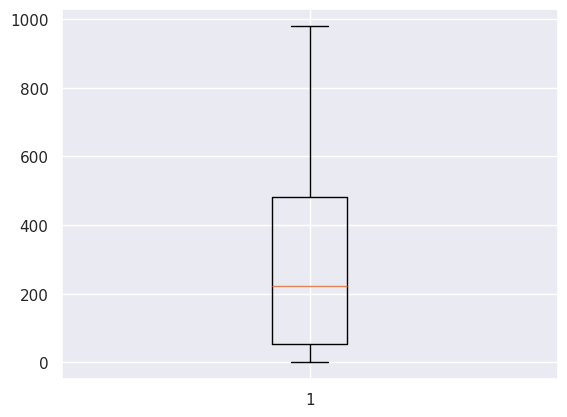

In [ ]:
#creating plot
plt.boxplot(df['block'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['block'].quantile(0.25)
Q3 = df['block'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-508.0, 1116.0)

In [ ]:
df.block =df.block.clip(lower_bound, upper_bound)

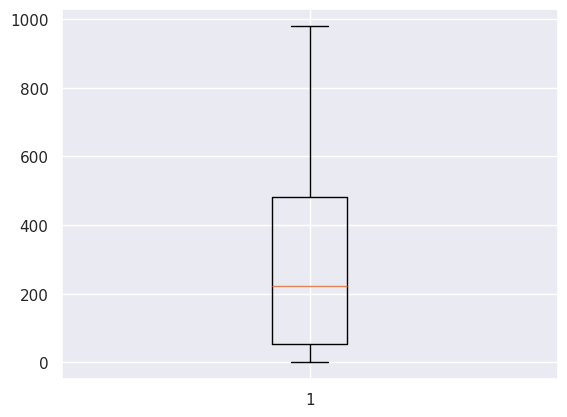

In [ ]:
#creating plot
plt.boxplot(df['block'])
#show plot
plt.show()

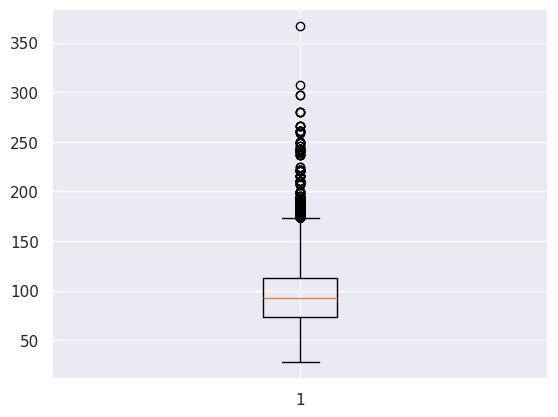

In [ ]:
#creating plot
plt.boxplot(df['floor_area_sqm'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['floor_area_sqm'].quantile(0.25)
Q3 = df['floor_area_sqm'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(13.0, 173.0)

In [ ]:
df.floor_area_sqm =df.floor_area_sqm.clip(lower_bound, upper_bound)

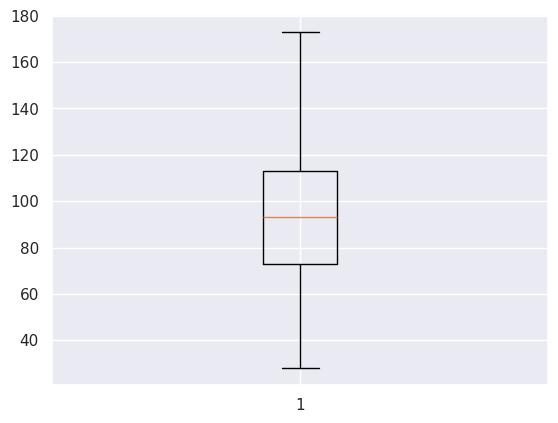

In [ ]:
#creating plot
plt.boxplot(df['floor_area_sqm'])
#show plot
plt.show()

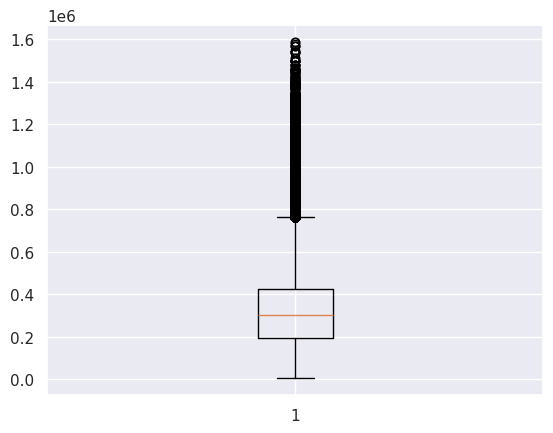

In [ ]:
#creating plot
plt.boxplot(df['resale_price'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['resale_price'].quantile(0.25)
Q3 = df['resale_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-145500.0, 762500.0)

In [ ]:
df.resale_price =df.resale_price.clip(lower_bound, upper_bound)

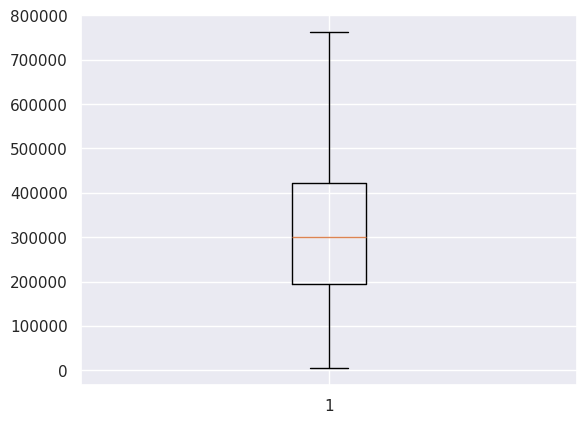

In [ ]:
#creating plot
plt.boxplot(df['resale_price'])
#show plot
plt.show()

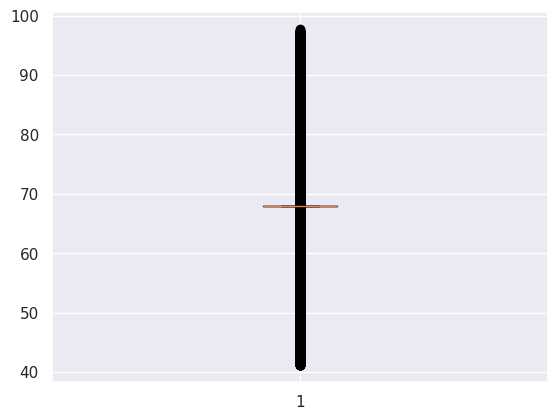

In [ ]:
#creating plot
plt.boxplot(df['remaining_lease'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['remaining_lease'].quantile(0.25)
Q3 = df['remaining_lease'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(68.0, 68.0)

In [ ]:
df.remaining_lease =df.remaining_lease.clip(lower_bound, upper_bound)

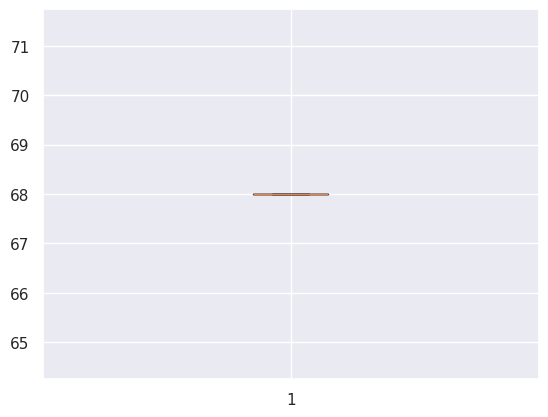

In [ ]:
#creating plot
plt.boxplot(df['remaining_lease'])
#show plot
plt.show()

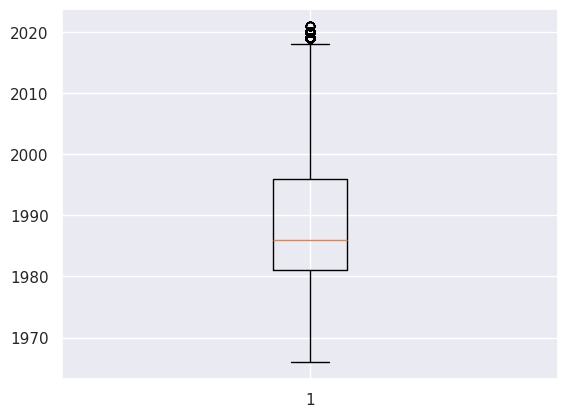

In [ ]:
#creating plot
plt.boxplot(df['lease_commence_date'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['lease_commence_date'].quantile(0.25)
Q3 = df['lease_commence_date'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(1958.5, 2018.5)

In [ ]:
df.lease_commence_date =df.lease_commence_date.clip(lower_bound, upper_bound)

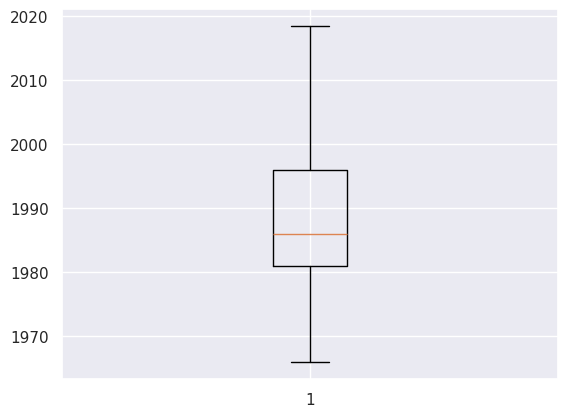

In [ ]:
#creating plot
plt.boxplot(df['lease_commence_date'])
#show plot
plt.show()

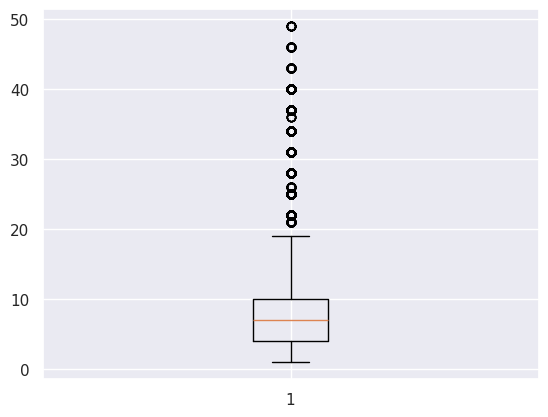

In [ ]:
#creating plot
plt.boxplot(df['storey_lower_bound'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['storey_lower_bound'].quantile(0.25)
Q3 = df['storey_lower_bound'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-5.0, 19.0)

In [ ]:
df.storey_lower_bound =df.storey_lower_bound.clip(lower_bound, upper_bound)

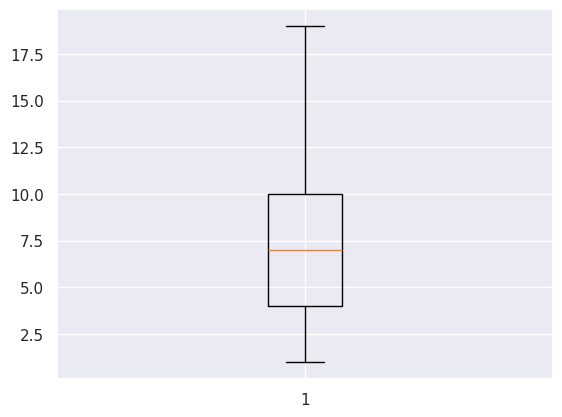

In [ ]:
#creating plot
plt.boxplot(df['storey_lower_bound'])
#show plot
plt.show()

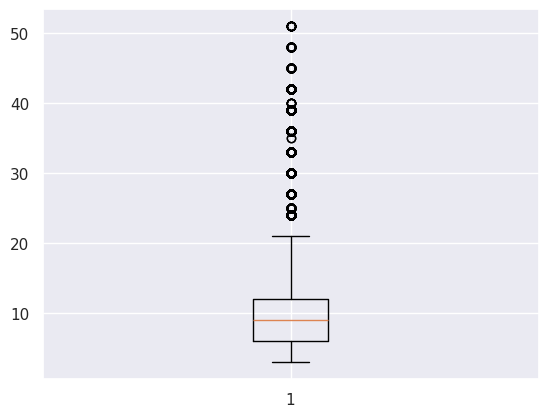

In [ ]:
#creating plot
plt.boxplot(df['storey_upper_bound'])
#show plot
plt.show()

In [ ]:
#IQR
Q1 = df['storey_upper_bound'].quantile(0.25)
Q3 = df['storey_upper_bound'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-3.0, 21.0)

In [ ]:
df.storey_upper_bound =df.storey_upper_bound.clip(lower_bound, upper_bound)

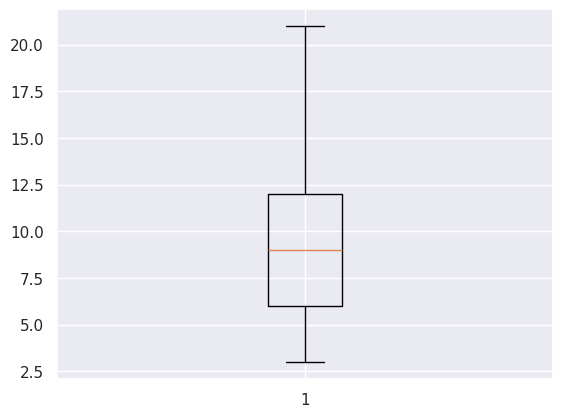

In [ ]:
#creating plot
plt.boxplot(df['storey_upper_bound'])
#show plot
plt.show()

EDA - Explotaratory Data Analysis

In [ ]:
object_data_cols = [var for var in df.columns if df[var].dtype == 'object']
object_data_cols

['town', 'flat_type', 'street_name', 'flat_model']

In [ ]:
df.to_csv('flatedit.csv', index=False)


In [ ]:
from google.colab import files
csv_filename = 'flatedit.csv'
df.to_csv(csv_filename, index=False)

# Download the file to your local machine
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding the Catogorical Variable

In [ ]:
df6 = df.copy()
object_data_cols = [var for var in df6.columns if df6[var].dtype == 'object']
object_data_cols

['town', 'flat_type', 'street_name', 'flat_model']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
#list unique streetnames
streets =df6['street_name'].unique()
# map the street to provide input to ML model
streets_mapping = {street: idx + 1 for idx, street in enumerate(streets)}
streets_mapping

{'ANG MO KIO AVE 1': 1,
 'ANG MO KIO AVE 3': 2,
 'ANG MO KIO AVE 4': 3,
 'ANG MO KIO AVE 10': 4,
 'ANG MO KIO AVE 5': 5,
 'ANG MO KIO AVE 8': 6,
 'ANG MO KIO AVE 6': 7,
 'ANG MO KIO AVE 9': 8,
 'ANG MO KIO AVE 2': 9,
 'BEDOK RESERVOIR RD': 10,
 'BEDOK NTH ST 3': 11,
 'BEDOK STH RD': 12,
 'NEW UPP CHANGI RD': 13,
 'BEDOK NTH RD': 14,
 'BEDOK STH AVE 1': 15,
 'CHAI CHEE RD': 16,
 'CHAI CHEE DR': 17,
 'BEDOK NTH AVE 4': 18,
 'BEDOK STH AVE 3': 19,
 'BEDOK STH AVE 2': 20,
 'BEDOK NTH ST 2': 21,
 'BEDOK NTH ST 4': 22,
 'BEDOK NTH AVE 2': 23,
 'BEDOK NTH AVE 3': 24,
 'BEDOK NTH AVE 1': 25,
 'BEDOK NTH ST 1': 26,
 'CHAI CHEE ST': 27,
 'SIN MING RD': 28,
 'SHUNFU RD': 29,
 'BT BATOK ST 11': 30,
 'BT BATOK WEST AVE 8': 31,
 'BT BATOK WEST AVE 6': 32,
 'BT BATOK ST 21': 33,
 'BT BATOK EAST AVE 5': 34,
 'BT BATOK EAST AVE 4': 35,
 'HILLVIEW AVE': 36,
 'BT BATOK CTRL': 37,
 'BT BATOK ST 31': 38,
 'BT BATOK EAST AVE 3': 39,
 'TAMAN HO SWEE': 40,
 'TELOK BLANGAH CRES': 41,
 'BEO CRES': 42,
 'TELOK B

In [ ]:
# alter the column with the mapped columns
df6['street_name'] = df6['street_name'].map(streets_mapping)
# display the dataframe
df6.head(2)

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
0,ANG MO KIO,1 ROOM,309.0,1,31.0,Improved,1977.0,9000.0,68.0,1990,1,10,12
1,ANG MO KIO,1 ROOM,309.0,1,31.0,Improved,1977.0,6000.0,68.0,1990,1,4,6


In [ ]:
df6['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [ ]:
category_mapping ={'1 ROOM':1, '2 ROOM':2, '3 ROOM':3, '4 ROOM':4, '5 ROOM':5, 'EXECUTIVE':6, 'MULTI-GENERATION':7}

# alter the column with the mapped columns
df6['flat_type'] = df6['flat_type'].map(category_mapping)
# display the dataframe
df6.head(2)



,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
0,ANG MO KIO,1.0,309.0,1,31.0,Improved,1977.0,9000.0,68.0,1990,1,10,12
1,ANG MO KIO,1.0,309.0,1,31.0,Improved,1977.0,6000.0,68.0,1990,1,4,6


In [ ]:
df6['flat_type'].dtypes

dtype('float64')

In [ ]:
df6['flat_model'].unique()

array(['Improved', 'New Generation', 'Model A', 'Standard', 'Simplified',
       'Model A-Maisonette', 'Apartment', 'Maisonette', 'Terrace',
       '2-room', 'Improved-Maisonette', 'Multi Generation',
       'Premium Apartment', 'Adjoined flat', 'Premium Maisonette',
       'Model A2', 'Type S1', 'Type S2', 'DBSS', 'Premium Apartment Loft',
       '3Gen'], dtype=object)

In [ ]:
flat_model_mapping = {
    'Improved':1, 'New Generation':2, 'Model A':3, 'Standard':4, 'Simplified':5,
       'Model A-Maisonette':6, 'Apartment':7, 'Maisonette':8, 'Terrace':9,
       '2-room':10, 'Improved-Maisonette':11, 'Multi Generation':12,
       'Premium Apartment':13, 'Adjoined flat':14, 'Premium Maisonette':15,
       'Model A2':16, 'Type S1':17, 'Type S2':18, 'DBSS':19, 'Premium Apartment Loft':20,
       '3Gen':21
    }

 # alter the column with the mapped columns
df6['flat_model'] = df6['flat_model'].map(flat_model_mapping)
# display the dataframe
df6.head(2)





,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
0,ANG MO KIO,1.0,309.0,1,31.0,1,1977.0,9000.0,68.0,1990,1,10,12
1,ANG MO KIO,1.0,309.0,1,31.0,1,1977.0,6000.0,68.0,1990,1,4,6


In [ ]:
df6['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI',
       'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SENGKANG',
       'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN',
       'LIM CHU KANG', 'SEMBAWANG', 'BUKIT PANJANG', 'PASIR RIS',
       'PUNGGOL'], dtype=object)

In [ ]:
town_mapping ={
      'ANG MO KIO':1, 'BEDOK':2, 'BISHAN':3, 'BUKIT BATOK':4, 'BUKIT MERAH':5,
       'BUKIT TIMAH':6, 'CENTRAL AREA':7, 'CHOA CHU KANG':8, 'CLEMENTI':9,
       'GEYLANG':10, 'HOUGANG':11, 'JURONG EAST':12, 'JURONG WEST':13,
       'KALLANG/WHAMPOA':14, 'MARINE PARADE':15, 'QUEENSTOWN':16, 'SENGKANG':17,
       'SERANGOON':18, 'TAMPINES':19, 'TOA PAYOH':20, 'WOODLANDS':21, 'YISHUN':22,
       'LIM CHU KANG':23, 'SEMBAWANG':24, 'BUKIT PANJANG':25, 'PASIR RIS':26,
       'PUNGGOL':27
    }

# alter the column with the mapped columns
df6['town'] = df6['town'].map(town_mapping)
# display the dataframe
df6.head(2)


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
0,1,1.0,309.0,1,31.0,1,1977.0,9000.0,68.0,1990,1,10,12
1,1,1.0,309.0,1,31.0,1,1977.0,6000.0,68.0,1990,1,4,6


In [ ]:
from google.colab import files
csv_file = 'finalflat.csv'
df6.to_csv(csv_file, index=False)

# Download the file to your local machine
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlation

In [ ]:
corrm = df6.corr()
corrm

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,relese_year,relese_month,storey_lower_bound,storey_upper_bound
town,1.000000,0.207405,0.048063,0.586298,0.200047,0.176519,0.331717,0.124027,NaN,0.124314,0.005693,-0.018673,-0.018422
flat_type,0.207405,1.000000,0.127267,0.384084,0.954821,0.289468,0.400688,0.590276,NaN,0.100167,0.003914,0.076969,0.077297
block,0.048063,0.127267,1.000000,0.040420,0.188262,-0.019794,-0.008943,-0.089873,NaN,-0.121924,-0.001146,-0.126498,-0.126519
street_name,0.586298,0.384084,0.040420,1.000000,0.352042,0.379699,0.735199,0.380163,NaN,0.318395,0.010863,0.083381,0.083983
floor_area_sqm,0.200047,0.954821,0.188262,0.352042,1.000000,0.250350,0.376873,0.563672,NaN,0.060261,0.002704,0.042803,0.042990
flat_model,0.176519,0.289468,-0.019794,0.379699,0.250350,1.000000,0.382356,0.286592,NaN,0.180951,0.004038,0.039336,0.039733
lease_commence_date,0.331717,0.400688,-0.008943,0.735199,0.376873,0.382356,1.000000,0.548259,NaN,0.436069,0.012169,0.157935,0.158283
resale_price,0.124027,0.590276,-0.089873,0.380163,0.563672,0.286592,0.548259,1.000000,NaN,0.694101,0.021427,0.211448,0.213928
remaining_lease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relese_year,0.124314,0.100167,-0.121924,0.318395,0.060261,0.180951,0.436069,0.694101,NaN,1.000000,-0.006669,0.098256,0.100136


Heatmap

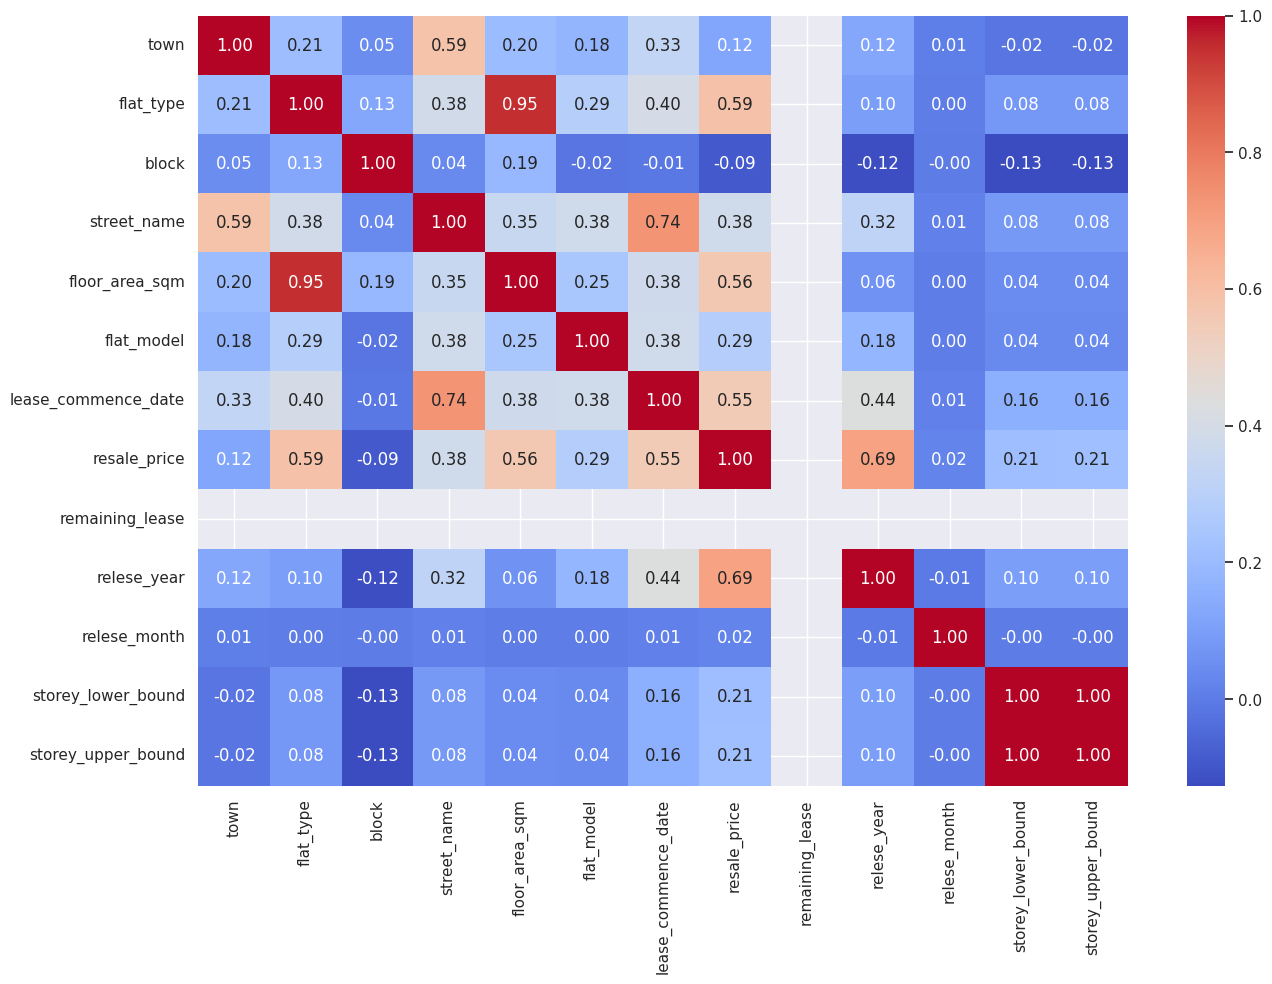

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(corrm, annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

ML Model

Splitting

In [ ]:
x = df6.drop(['resale_price'], axis=1)
y = df6['resale_price']
#splitting the data into training set with the ratio oof 8:2
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=72)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(751927, 12)
(187982, 12)
(751927,)
(187982,)


Scalling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
x_train_scaled,x_test_scaled

(array([[-1.62493728, -1.0717958 ,  0.70247685, ..., -0.46573606,
         -1.25390025, -1.25739843],
        [ 1.06759131,  2.09766243,  1.37238277, ...,  1.00271287,
          0.764226  ,  0.76118089],
        [-0.47099646, -1.0717958 , -0.64875384, ..., -1.34680543,
         -1.25390025, -1.25739843],
        ...,
        [ 1.45223825,  1.04117636, -0.18438723, ..., -0.17204628,
          1.43693476,  1.43404067],
        [ 0.29829743, -0.01530972, -0.75532978, ...,  0.4153333 ,
          1.43693476,  1.43404067],
        [-1.24029034, -0.01530972,  0.45126213, ...,  0.70902309,
         -0.5811915 , -0.58453865]]),
 array([[ 0.29829743,  2.09766243, -0.54598418, ...,  0.4153333 ,
          2.78235226,  2.77976022],
        [ 1.5804539 ,  1.04117636,  0.6453826 , ..., -0.17204628,
         -0.5811915 , -0.58453865],
        [ 0.42651307, -0.01530972, -1.10170159, ...,  0.12164351,
          0.09151725,  0.08832112],
        ...,
        [-0.34278081, -1.0717958 ,  0.04398979, ..., -

Model fit

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

Random forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
#create model
rf_regressor =RandomForestRegressor(random_state = 42)
#fit model
model = rf_regressor.fit(x_train,y_train)

y_pred = rf_regressor.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rf_r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", rf_r2)


Mean Absolute Error (MAE): 13987.198179131079
Mean Squared Error (MSE): 409880697.8062416
Root Mean Squared Error (RMSE): 20245.51055928799
R-squared (R2) Score: 0.9851895963718698


Save the model

In [ ]:
model = rf_regressor.fit(x_train,y_train)


NameError: name 'rf_regressor' is not defined

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
import pickle

pkl_filename = "FlatRFRegresson.pkl"
with open(pkl_filename,'wb') as file:
  pickle.dump(model,file)

files.download(pkl_filename)
print("Saved to disk")

NameError: name 'model' is not defined